In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# WEATHER

il dataset comprende diverse colonne che rappresentano le condizioni meteorologiche della città di seattle dal 2012 al 2015

In [4]:
data = pd.read_csv("/content/drive/MyDrive/weather.csv")
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


## PULIZIA DEI DATI

In [8]:
missing_values = data.isnull().sum()
print("\nValori mancanti per colonna:")
print(missing_values)


Valori mancanti per colonna:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


In [9]:
duplicate_values = data.duplicated().sum()
print("\nNumero di righe duplicate:", duplicate_values)


Numero di righe duplicate: 0


## Analisi dati

In [5]:
print("rows and columns:" + str(data.shape))
print(list(data.columns))

rows and columns:(1461, 6)
['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather']



colonne:
*   date: data delle misurazioni
*   precipitation: precipitaioni in mm - se non sono a zero o ha piovuto o ha nevicato
* temp_max: temperatura massima in gradi
* temp_min: temperatura minima in gradi
* wind: velocità del vento
* weather: effettivo tempo meteorologico

In [6]:
data.describe().style.background_gradient()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


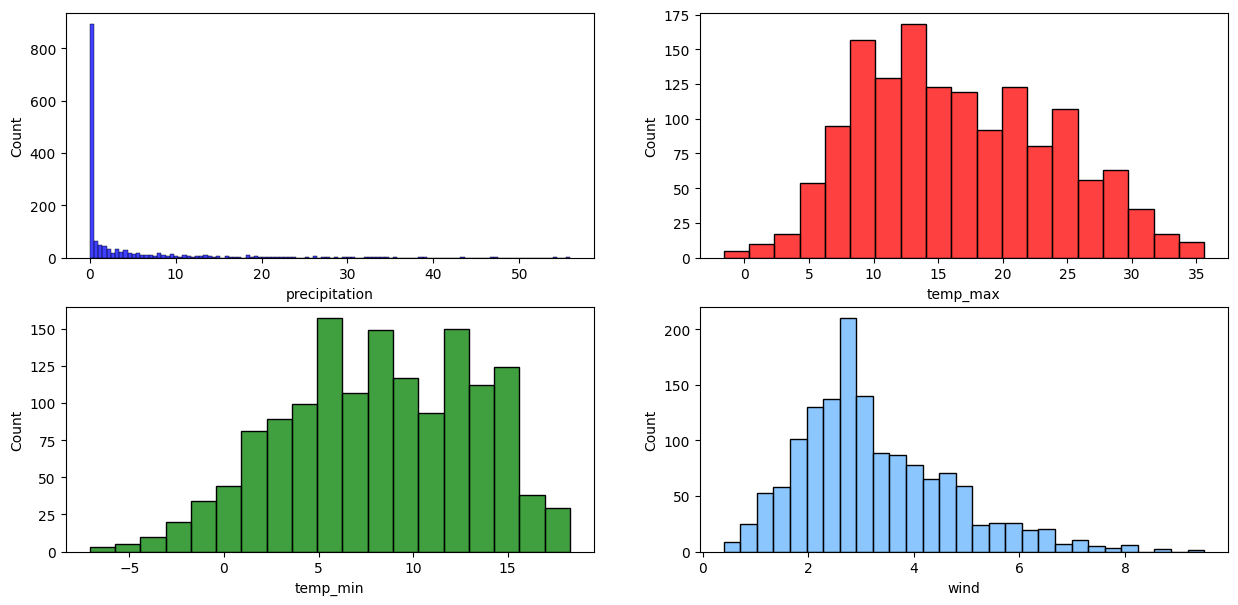

In [7]:
fig, axs = plt.subplots(2,2, figsize=(15,7))
axs = axs.flatten()
sns.histplot(data['precipitation'],color='blue',ax=axs[0])
sns.histplot(data['temp_max'],color='red',ax=axs[1])
sns.histplot(data['temp_min'],color='green',ax=axs[2])
sns.histplot(data['wind'],color='#66b3ff',ax=axs[3])
plt.show()

<ipython-input-32-fee14057c98f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.background_gradient(cmap="Blues")
<ipython-input-32-fee14057c98f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = np.round(data.corr(), 2)


<Axes: >

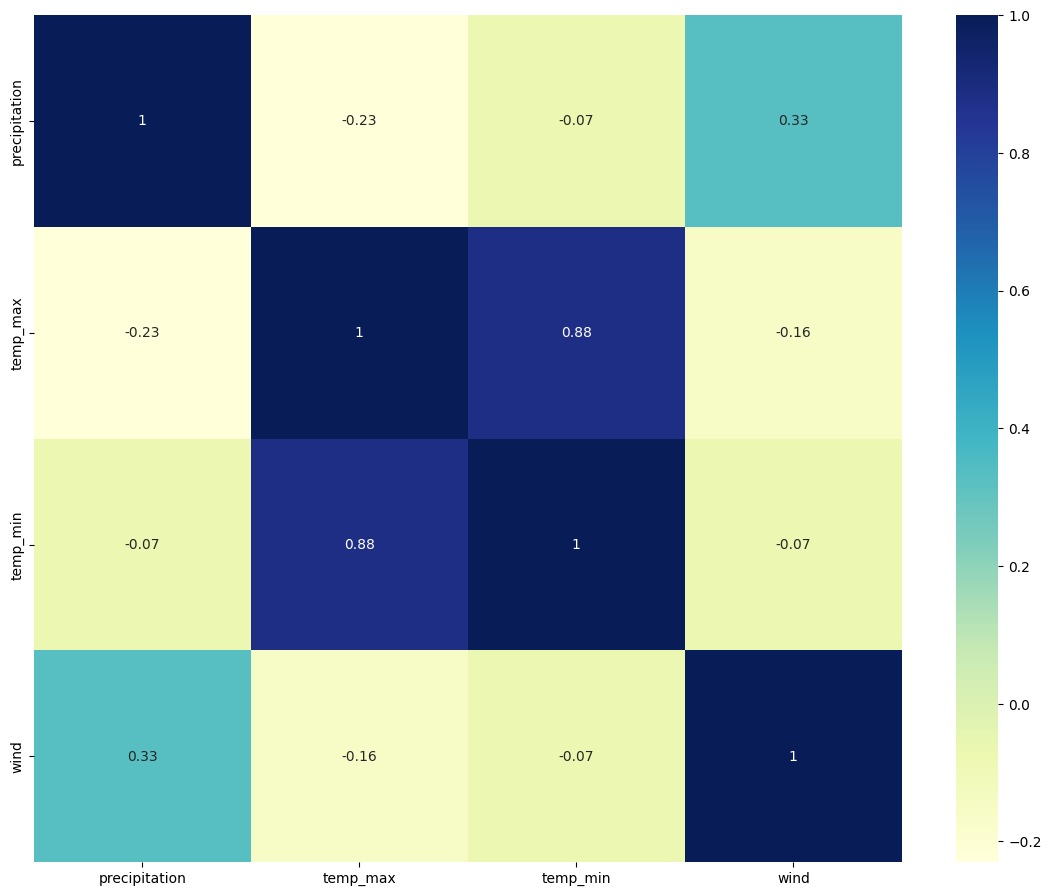

In [32]:
data.corr().style.background_gradient(cmap="Blues")
corr_matrix = np.round(data.corr(), 2)
plt.figure(figsize=(14,11))
sns.heatmap(
    corr_matrix,
    cmap="YlGnBu",
    annot=True,
)

correlation between temp_max and temp_min and a small correlation between precipitation and wind

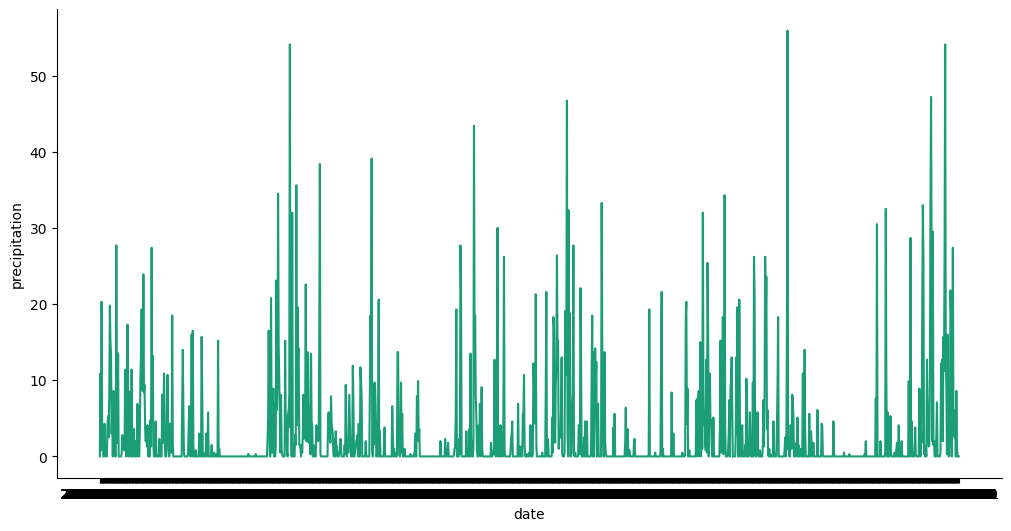

In [20]:
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['precipitation']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('precipitation')

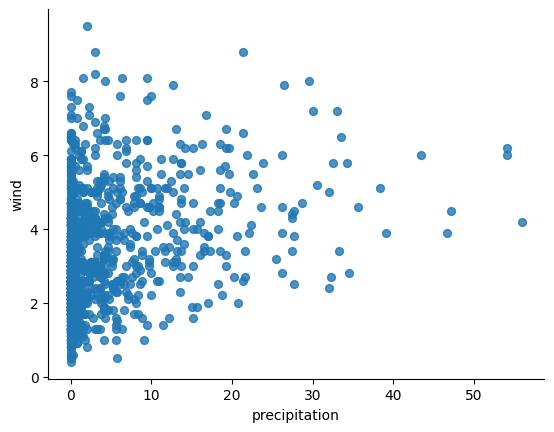

In [21]:
data.plot(kind='scatter', x='precipitation', y='wind', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## MACHINE LEARNING


In [74]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

In [57]:
testdata = data.drop(columns="date")
testdata["its_raining"] = testdata['weather'].isin(['rain', 'snow']).astype(int)
testdata = testdata.drop(columns="weather")

testdata.head()

,precipitation,temp_max,temp_min,wind,its_raining
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,1
2,0.8,11.7,7.2,2.3,1
3,20.3,12.2,5.6,4.7,1
4,1.3,8.9,2.8,6.1,1


In [58]:
y = testdata["its_raining"]
x = testdata.drop(columns="its_raining")

rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(testdata, y)

x_rus.head()

,precipitation,temp_max,temp_min,wind,its_raining
0,0.0,32.8,16.7,2.1,0
1,0.0,12.8,7.2,2.6,0
2,0.0,27.8,13.3,2.9,0
3,0.0,18.3,11.1,2.1,0
4,0.0,21.1,14.4,2.9,0


In [59]:
x_train, x_test, y_train, y_test = train_test_split(
    x_rus, y_rus, test_size=0.2, random_state=42
)

### Logistic regression

In [45]:
from sklearn.linear_model import LogisticRegression

In [64]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
print("Logistic Regression Accuracy: ", lr.score(x_test, y_test))

Logistic Regression Accuracy:  1.0


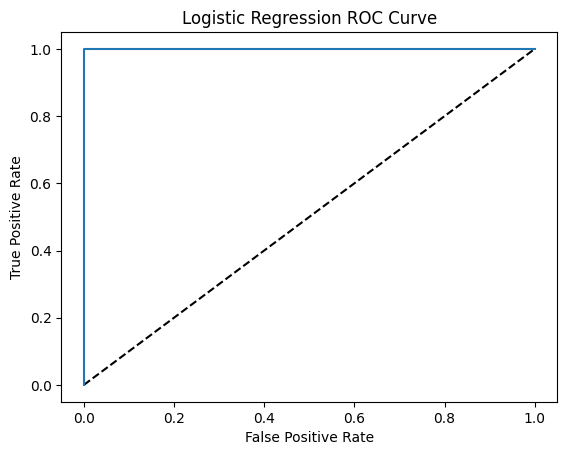

In [63]:
# Probabilities
pred = lr.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1])
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

### KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier


In [69]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
#print(f"KNN Score: {knn.score(x_test, y_test)}")
print("KNN F1 Score: ", f1_score(y_test, prediction, average=None))


test_accuracy=accuracy_score(y_test,prediction)*100
print("Accuracy for our testing dataset without tuning is : {:.2f}%".format(test_accuracy) )
# print("KNN R2 Score: ", r2_score(y_test, knn.predict(x_test)))

KNN F1 Score:  [0.95238095 0.94166667]
Accuracy for our testing dataset without tuning is : 94.76%


Text(0.5, 1.0, 'Confusion matrix pre tuning')

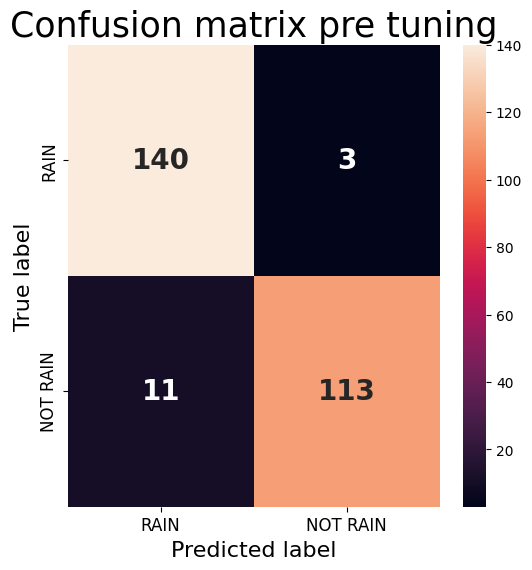

In [71]:
_, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(
    confusion_matrix(y_test, prediction),
    annot=True,
    fmt="d",
    annot_kws={"size": 20, "weight": "bold"},
)
labels = ["RAIN", "NOT RAIN"]
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.set_ylabel("True label", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=16)
ax.set_title("Confusion matrix pre tuning", fontsize=25)

In [75]:
params = {
    'n_neighbors' : [7,9,11,13,15, 22],
    'metric' : ['minkowski','euclidean','manhattan'],
    'weights': ['uniform', 'distance'],
}


knn = KNeighborsClassifier()
grid = GridSearchCV(knn, params, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=False, verbose=1) #cv=10 è altino
grid.fit(x_train, y_train)

print("Best estimator:", grid.best_estimator_)
print("Optimized hyperparameters: ", grid.best_params_)
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(grid.best_score_*100))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
Optimized hyperparameters:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy for our testing dataset with tuning is : 96.53%


In [76]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=22)
knn.fit(x_test, y_test)
prediction=knn.predict(x_test)
test_accuracy=accuracy_score(y_test,prediction)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 92.51%


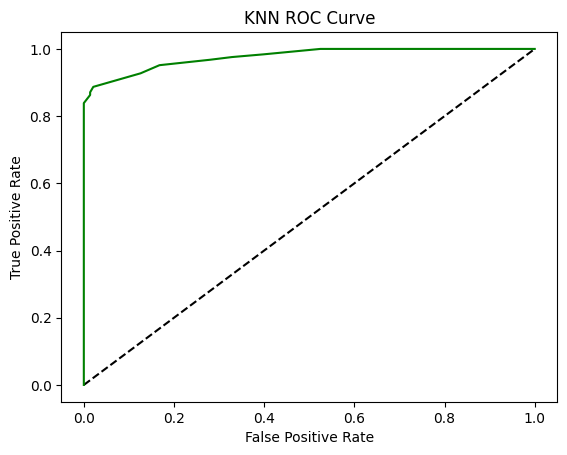

In [78]:
pred = knn.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1])
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="KNN", color="g")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve")
plt.show()

Text(0.5, 1.0, 'Confusion matrix post tuning')

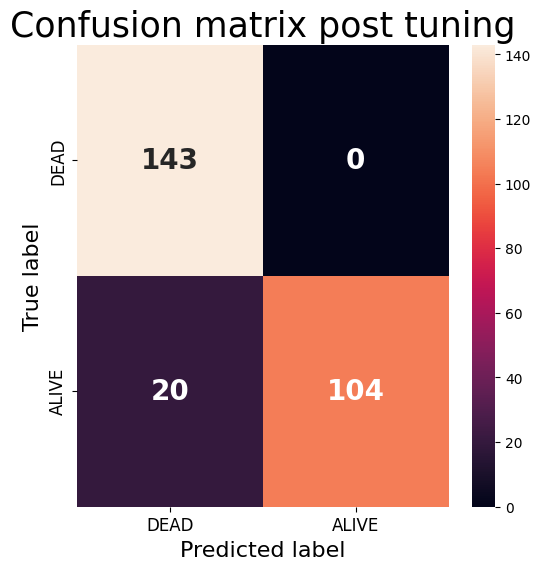

In [79]:
_, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(
    confusion_matrix(y_test, prediction),
    annot=True,
    fmt="d",
    annot_kws={"size": 20, "weight": "bold"},
)

labels = ["DEAD", "ALIVE"]
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.set_ylabel("True label", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=16)
ax.set_title("Confusion matrix post tuning", fontsize=25)